# Create a MIP of neurons within the EM dataset
### Brandon Pratt, 12/10/2021

In [5]:
# import python libraries
import sys
import os
import nrrd
import cv2 as cv
import numpy as np
import tqdm
import seaborn as sea
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
%matplotlib inline
from caveclient import CAVEclient
from meshparty import trimesh_io, trimesh_vtk
from template_alignment import warp_points_FANC_to_template
import npimage # pip install git+https://github.com/jasper-tms/npimage
import npimage.graphics
from PIL import Image


In [2]:
# setup the environment
client = CAVEclient('fanc_production_mar2021')

mm = trimesh_io.MeshMeta(
    cv_path=client.info.segmentation_source(),
    disk_cache_path=os.path.expanduser('~/.meshes'),
    map_gs_to_https=True
)

In [3]:
# download mesh
segid = 648518346495863754 # HP
my_mesh = mm.mesh(
    seg_id=segid, # hair plate segid
    remove_duplicate_vertices=True,
    merge_large_components=False  # False is faster but probably worse quality
)

In [4]:
# Remove any mesh faces in the neck connective or brain,
# since those can't be warped to the VNC template
y_cutoff = 322500 + 1e-4  # y=75000vox * 4.3nm/vox, plus a small epsilon
# Find row numbers of vertices that are out of bounds
out_of_bounds_vertices = (my_mesh.vertices[:, 1] < y_cutoff).nonzero()[0]
in_bounds_faces = np.isin(my_mesh.faces,
                          out_of_bounds_vertices,
                          invert=True).all(axis=1)
my_mesh.faces = my_mesh.faces[in_bounds_faces]

print('Warping to template')
my_mesh.vertices = warp_points_FANC_to_template(my_mesh.vertices, input_units='nanometers', output_units='microns')

Warping to template


In [5]:
# Render into template-sized numpy array

# JRC2018_VNC_FEMALE.nrrd is 660x1342x358  (in xyz order) at 0.4 micron
# Unisex template which is used for generating the MCFO MIPs is 660 x 1290 x 382 (in xyz order) at 0.4 micron
# voxel size>

# Can convert between the female and unisex template by following the conversion here: https://www.janelia.org/open-science/jrc-2018-brain-templates

'''
TODO figure out the image size, voxel size, and offset used in the images
made available in the Janelia MCFO collections, and render with those settings.
'''

print('Rendering mesh faces')
template_vol = np.zeros((660, 1342, 358), dtype=np.uint8)
voxel_size = 0.4  # 0.4 microns
my_mesh.vertices = my_mesh.vertices / voxel_size
n = my_mesh.n_faces
#for i, face in enumerate(my_mesh.faces)):
for face in tqdm.tqdm(my_mesh.faces):
    #print(i, '/', n)
    npimage.graphics.drawtriangle(
        template_vol,
        my_mesh.vertices[face[0]],
        my_mesh.vertices[face[1]],
        my_mesh.vertices[face[2]],
        255,
        fill_value=255
        #voxel_size=0.4)
    )

npimage.save(template_vol, '{}.nrrd'.format(segid), dim_order='xyz')

Rendering mesh faces


100%|██████████| 1195315/1195315 [03:30<00:00, 5687.74it/s]


In [2]:
# load in nrrd file associated with EM neuron volume
segid = 648518346495863754 #648518346486034056
em_data, em_header = nrrd.read(str(segid)+'.nrrd')
print(em_data.shape)
print(em_header)

(660, 1342, 358)
OrderedDict([('type', 'uint8'), ('dimension', 3), ('sizes', array([ 660, 1342,  358])), ('encoding', 'gzip')])


### Load in VNC template

MIPs don't map well onto the Unisex template, but okay onto the female template

In [3]:
# load in rnnd asociated with JRC2018_VNC_unisex is 660, 1290,  382 (in xyz order) at 0.4 micron
# jan_vnc_data, jan_vnc_header = nrrd.read('JRC2018_VNC_UNISEX_4iso.nrrd') # unisex template, which is used for mips
jan_vnc_data, jan_vnc_header = nrrd.read('JRC2018_VNC_FEMALE_4iso.nrrd') # female tempate
print(jan_vnc_data.shape)
print(jan_vnc_header)

(660, 1342, 358)
OrderedDict([('type', 'uint16'), ('encoding', 'gzip'), ('endian', 'big'), ('dimension', 3), ('sizes', array([ 660, 1342,  358])), ('space dimension', 3), ('space directions', array([[0.4, 0. , 0. ],
       [0. , 0.4, 0. ],
       [0. , 0. , 0.4]])), ('space units', ['microns', 'microns', 'microns'])])


MIP Image Shape (1209, 573, 3)


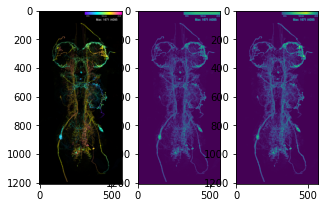

In [8]:
# Import MIP as a comparasion, third dimension is color
# im_file ='VT040055-20180720_62_H1-m-40x-VNC-GAL4-JRC2018_VNC_Unisex-8186296-CDM_2.png'
im_file =['R93D09_AE_01_01_fA01v_C100815_20100816103753781_ADeDBDe.tif',
          'VT025967_AE_01_00_fA00v_C140416_20140417212439489_ADeDBDe.tif',
          'R48A07_AE_01_02_fA01v_C080814_20080814141215078_ADeDBDe.tif',
          'VT040055-20180720_62_H1-m-40x-VNC-GAL4-JRC2018_VNC_Unisex-8186296-CDM_2.png',
          'R48A07-20181012_63_A2-f-40x-VNC-GAL4-JRC2018_VNC_Unisex-8231972-CDM_1.png'
          ]
          
          
im = Image.open(im_file[4])
mip= np.array(im)
print('MIP Image Shape', mip.shape)
plt.figure(1, figsize = [5,8])
plt.subplot(1,3,1)
plt.imshow(mip)
plt.subplot(1,3,2)
ave_mip = np.mean(mip, axis=2)
plt.imshow(ave_mip)
plt.subplot(1,3,3)
plt.imshow(np.array(im.convert('L')))

### Visualize each VNC volume

In [7]:
def plot_2d_projection(fig, jan_vnc_2d, em_vnc_2d):
    
    # find pixels of em neuron 
    neuron_location = np.where(em_vnc_2d > 0)
    neuron_pixels = em_vnc_2d[neuron_location[0],neuron_location[1]]
    
    # binarize janelia vnc
    ret, thresh_image = cv.threshold(jan_vnc_2d,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
    
    # add em neuron to female vnc mip
    thresh_image[neuron_location[0],neuron_location[1]] = neuron_pixels

    # plot overlay
    plt.imshow(thresh_image, cmap='Greys')

In [8]:
def return_combined_projection(jan_vnc_2d, em_vnc_2d):   
    # find pixels of em neuron 
    neuron_location = np.where(em_vnc_2d > 0)
    neuron_pixels = em_vnc_2d[neuron_location[0],neuron_location[1]]
    
    # binarize janelia vnc
    ret, thresh_image = cv.threshold(jan_vnc_2d,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
    
    # add em neuron to female vnc mip
    thresh_image[neuron_location[0],neuron_location[1]] = 255 #neuron_pixels
    
    zero_idxs = np.where(thresh_image==0)
    thresh_image[np.where(thresh_image==255)]=0
    thresh_image[zero_idxs] = 255
    
    return thresh_image

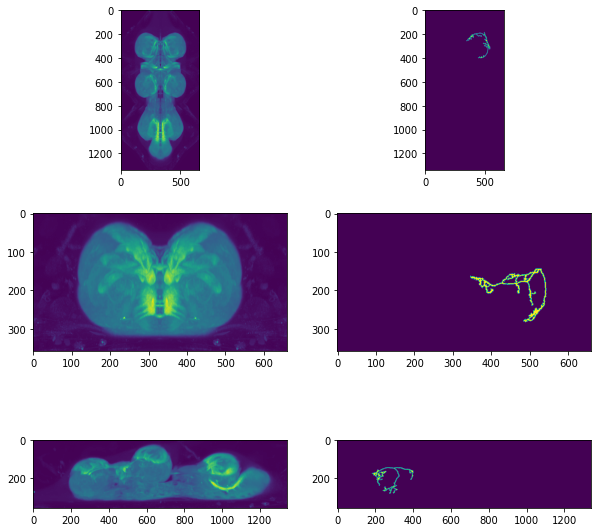

In [9]:
# max intensity projection of VNC
# janiela VNC

# max intensity z
max_int_jan_vnc = np.transpose(np.max(jan_vnc_data, axis =2))
plt.figure(1, figsize=[10,10])
plt.subplot(3,2,1)
plt.imshow(max_int_jan_vnc)

# max intensity y
max_int_jan_vnc_y = np.transpose(np.max(jan_vnc_data, axis =1))
plt.subplot(3,2,3)
plt.imshow(max_int_jan_vnc_y)

# max intensity x
max_int_jan_vnc_x = np.transpose(np.max(jan_vnc_data, axis =0))
plt.subplot(3,2,5)
plt.imshow(max_int_jan_vnc_x)

# EM VNC
max_int_em_vnc = np.transpose(np.max(em_data, axis =2))
plt.subplot(3,2,2)
plt.imshow(max_int_em_vnc)

max_int_em_vnc_y = np.transpose(np.max(em_data, axis =1))
plt.subplot(3,2,4)
plt.imshow(max_int_em_vnc_y)

max_int_em_vnc_x = np.transpose(np.max(em_data, axis =0))
plt.subplot(3,2,6)
plt.imshow(max_int_em_vnc_x)



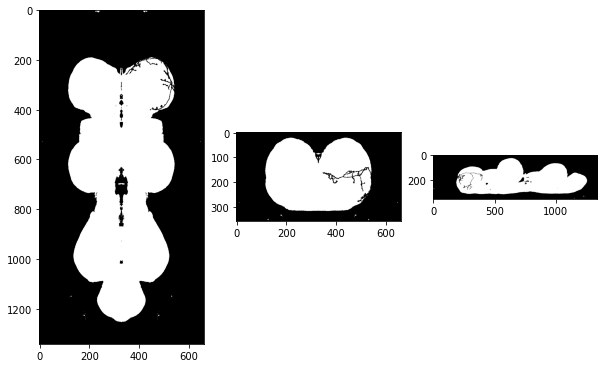

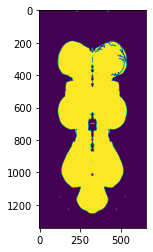

In [10]:
# Overlay the EM neuron in 2D with the Janiela template

# max intensity z
fig= plt.figure(1, figsize = [10,20])
plt.subplot(1,3,1)
plot_2d_projection(fig, max_int_jan_vnc, max_int_em_vnc)

plt.subplot(1,3,2)
plot_2d_projection(fig, max_int_jan_vnc_y, max_int_em_vnc_y)

plt.subplot(1,3,3)
plot_2d_projection(fig, max_int_jan_vnc_x, max_int_em_vnc_x)

# return 2D projection of the neuron + VNC
combined_img = return_combined_projection(max_int_jan_vnc, max_int_em_vnc)
plt.figure(2)
plt.imshow(combined_img)



### Add the neuron to janelia VNC template in 3D

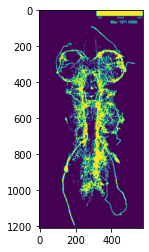

In [11]:
# filter average mip to remove background
px_threshold = 25
ave_mip[ave_mip < px_threshold]=0
ave_mip = ave_mip.astype(int)
ave_mip[ave_mip>0] = 255

# truncate the color bar off
plt.imshow(ave_mip)

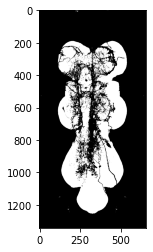

In [12]:
plot_2d_projection(fig, max_int_jan_vnc, ave_mip)

janeila VNC image size (1342, 660)
MIP image size (1209, 573)
resized janeila VNC image size (1209, 573)


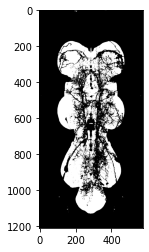

In [13]:
# check shape of the two arrays
print('janeila VNC image size', max_int_jan_vnc.shape)
print('MIP image size', ave_mip.shape)

# resize/rescale the janelia mip to try to align it to the 
resize_vnc_img = cv.resize(max_int_jan_vnc, dsize=(ave_mip.shape[1],ave_mip.shape[0]), interpolation=cv.INTER_CUBIC)
print('resized janeila VNC image size', resize_vnc_img.shape)

fig = plt.figure(1)
plot_2d_projection(fig, resize_vnc_img, ave_mip)


### Translate VNC template

Negative values for the tx value will shift the image to the left

Positive values for  tx shifts the image to the right

Negative values for  ty shifts the image up

Positive values for  ty will shift the image down

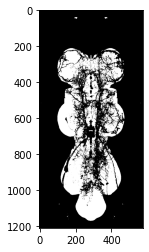

In [14]:
# set translation parameters
tx = 0
ty = 40
T = np.float32([[1, 0, tx], [0, 1, ty]])
  
# We use warpAffine to transform
# the image using the matrix, T
translate_vnc_img = cv.warpAffine(resize_vnc_img, T, (resize_vnc_img.shape[1], resize_vnc_img.shape[0]))

fig = plt.figure(1)
plot_2d_projection(fig, translate_vnc_img, ave_mip)

### combined VNC and EM neuron and determine match to MIP

In [15]:
# check shape of the two arrays
print('janeila VNC image size', combined_img.shape)
print('MIP image size', ave_mip.shape)

# resize/rescale the janelia mip to try to align it to the 
resize_combined_img = cv.resize(combined_img, dsize=(ave_mip.shape[1],ave_mip.shape[0]), interpolation=cv.INTER_CUBIC)
print('resized combined image size', resize_combined_img.shape)
translate_combined_img = cv.warpAffine(resize_combined_img, T, (resize_vnc_img.shape[1], resize_vnc_img.shape[0]))

# neuron_location = np.where(ave_mip > 0)
# neuron_pixels = ave_mip[neuron_location[0],neuron_location[1]]
# translate_combined_img[neuron_location[0],neuron_location[1]] = 125
# fig = plt.figure(1)
# plt.imshow(translate_combined_img, cmap='Greys')


janeila VNC image size (1342, 660)
MIP image size (1209, 573)
resized combined image size (1209, 573)


janeila EM image size (1342, 660)
MIP image size (1209, 573)
resized combined image size (1209, 573)


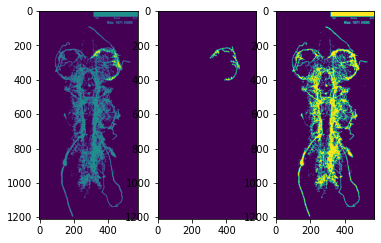

In [93]:
# check shape of the two arrays
print('janeila EM image size', max_int_em_vnc.shape)
print('MIP image size', ave_mip.shape)

# resize/rescale the janelia mip to try to align it to the 
tx = 0
ty = 40
T = np.float32([[1, 0, tx], [0, 1, ty]])
resize_em_img = cv.resize(max_int_em_vnc, dsize=(ave_mip.shape[1],ave_mip.shape[0]), interpolation=cv.INTER_CUBIC)
print('resized combined image size', resize_em_img.shape)
translate_em_img = cv.warpAffine(resize_em_img, T, (resize_em_img.shape[1], resize_em_img.shape[0]))
translate_em_img[np.where(translate_em_img>0)] = 255
combined_em_mip = translate_em_img + ave_mip

fig = plt.figure(1)
plt.subplot(1,3,1)
plt.imshow(combined_em_mip)
plt.subplot(1,3,2)
plt.imshow(translate_em_img)
plt.subplot(1,3,3)
plt.imshow(ave_mip)


### Align EM neuron to mips and create mip depth image

resize and translate (MCFO MIP) or just resize (Gen1 MIP) each slice of EM neuron to mip. Adjust encoding of depth (color spectrum) to match known MIP. 

MIP Image Shape (1209, 573, 3)
MIP image size (1209, 573)


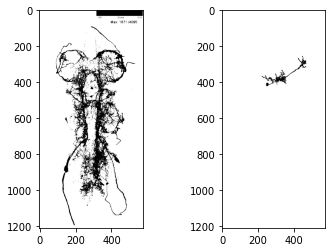

In [10]:
# load in nrrd file associated with EM neuron volume
segid = 648518346495863754 #648518346486034056 # CoHP8
em_data, em_header = nrrd.read(str(segid)+'.nrrd')

# load in MIP for transforming EM neuron
im_file =['R93D09_AE_01_01_fA01v_C100815_20100816103753781_ADeDBDe.tif',
          'VT025967_AE_01_00_fA00v_C140416_20140417212439489_ADeDBDe.tif',
          'R48A07_AE_01_02_fA01v_C080814_20080814141215078_ADeDBDe.tif',
          'VT040055-20180720_62_H1-m-40x-VNC-GAL4-JRC2018_VNC_Unisex-8186296-CDM_2.png',
          'R48A07-20181012_63_A2-f-40x-VNC-GAL4-JRC2018_VNC_Unisex-8231972-CDM_1.png'
          ]
                 
im = Image.open(im_file[4])
mip= np.array(im)
print('MIP Image Shape', mip.shape)
ave_mip = np.mean(mip, axis=2)
px_threshold = 25
ave_mip[ave_mip < px_threshold]=0
ave_mip = ave_mip.astype(int)
ave_mip[ave_mip>0] = 255
plt.figure(1)
plt.subplot(1,2,1)
plt.imshow(ave_mip, cmap='Greys')
print('MIP image size', ave_mip.shape)

# extract image parameters
height = ave_mip.shape[0]
width = ave_mip.shape[1]
depth = em_data.shape[2]

# set translation parameters
tx = 40 # dimensions are swapped from above
ty = 0
T = np.float32([[1, 0, tx], [0, 1, ty]])

transformed_em_neuron = np.zeros((height, width, em_data.shape[2]))

# Transform EM neuron into MCFO MIP format
for j in range(depth):
    # transform current image slice
    curr_slice = em_data[:,:,j]
    curr_slice[curr_slice>0] = 255
    
    # resize/rescale the janelia mip to try to align it to the 
    resize_img = cv.resize(curr_slice, dsize=(height,width), interpolation=cv.INTER_CUBIC)
    
    # Translate image
    translate_img = cv.warpAffine(resize_img, T, (resize_img.shape[1], resize_img.shape[0]))
    
    # Save transformed frame
    transformed_em_neuron[:,:,j] = np.transpose(translate_img)
    
plt.subplot(1,2,2)
plt.imshow(np.max(transformed_em_neuron, axis=2), cmap='Greys')

# Write to a NRRD file
save_filename = 'MCFO_mip_transformed_' + str(segid) + '.nrrd'
nrrd.write(save_filename, np.transpose(transformed_em_neuron, axes=[1,0,2]))
    

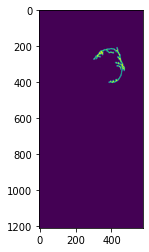

In [84]:
plt.imshow(translate_em_img)

### Check mip alignment

In [6]:
# untransformed
em_mip_untransformed_im = Image.open('648518346486034056.tif')
em_mip_untransformed = np.array(em_mip_untransformed_im)
print('em untransformed mip size', em_mip_untransformed.shape)

#transformed
# em_mip_transformed_im = Image.open('MCFO_mip_transformed_648518346486034056.tif')
em_mip_transformed_im = Image.open('MCFO_aligned_EM_neuron_648518346518629599.tif')
em_mip_transformed = np.array(em_mip_transformed_im)
print('em transformed mip size', em_mip_transformed.shape)

max_em_mip = np.max(em_mip_transformed, axis=2)

em untransformed mip size (1342, 660, 3)
em transformed mip size (1209, 573, 3)


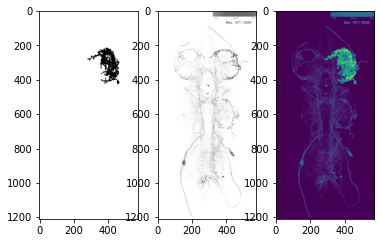

In [9]:
plt.figure(1)
plt.subplot(1,3,1)
plt.imshow(max_em_mip, cmap='Greys')

plt.subplot(1,3,2)
plt.imshow(ave_mip, cmap='Greys')

plt.subplot(1,3,3)
plt.imshow(max_em_mip + ave_mip)

In [3]:
# import python libraries
import os
import nrrd
import cv2 as cv
import numpy as np
import tqdm
from caveclient import CAVEclient
from meshparty import trimesh_io, trimesh_vtk
from template_alignment import warp_points_FANC_to_template
import npimage # pip install git+https://github.com/jasper-tms/npimage
import npimage.graphics

# setup the environment
client = CAVEclient('fanc_production_mar2021')

mm = trimesh_io.MeshMeta(
    cv_path=client.info.segmentation_source(),
    disk_cache_path=os.path.expanduser('~/.meshes'),
    map_gs_to_https=True
)

# download mesh
segid = 648518346518629599
my_mesh = mm.mesh(
    seg_id=segid, # em segid
    remove_duplicate_vertices=True,
    merge_large_components=False  # False is faster but probably worse quality
)

# Remove any mesh faces in the neck connective or brain,
# since those can't be warped to the VNC template
y_cutoff = 322500 + 1e-4  # y=75000vox * 4.3nm/vox, plus a small epsilon
# Find row numbers of vertices that are out of bounds
out_of_bounds_vertices = (my_mesh.vertices[:, 1] < y_cutoff).nonzero()[0]
in_bounds_faces = np.isin(my_mesh.faces,
                          out_of_bounds_vertices,
                          invert=True).all(axis=1)
my_mesh.faces = my_mesh.faces[in_bounds_faces]

print('Warping to template')
my_mesh.vertices = warp_points_FANC_to_template(my_mesh.vertices, input_units='nanometers', output_units='microns')

# Render into template-sized numpy array

# JRC2018_VNC_FEMALE.nrrd is 660x1342x358  (in xyz order) at 0.4 micron
# Unisex template which is used for generating the MCFO MIPs is 660 x 1290 x 382 (in xyz order) at 0.4 micron
# voxel size>

# Can convert between the female and unisex template by following the conversion here: https://www.janelia.org/open-science/jrc-2018-brain-templates
print('Rendering mesh faces')
template_vol = np.zeros((660, 1342, 358), dtype=np.uint8)
voxel_size = 0.4  # 0.4 microns
my_mesh.vertices = my_mesh.vertices / voxel_size
n = my_mesh.n_faces
for face in tqdm.tqdm(my_mesh.faces):
    npimage.graphics.drawtriangle(
        template_vol,
        my_mesh.vertices[face[0]],
        my_mesh.vertices[face[1]],
        my_mesh.vertices[face[2]],
        255,
        fill_value=255
        #voxel_size=0.4)
    )

print('Transform EM neuron volume into MCFO MIP coordinates')
# MCFO image parameters
height = 1209 # height of MCFO Mips
width = 573 # width of MCFO MIPs
depth = template_vol.shape[2]

# set translation parameters
tx = 40 # dimensions are swapped from above
ty = 0
T = np.float32([[1, 0, tx], [0, 1, ty]])

transformed_em_neuron = np.zeros((height, width, template_vol.shape[2]))

# Transform EM neuron into MCFO MIP format
for j in range(depth):
    # transform current image slice
    curr_slice = template_vol[:,:,j]
    curr_slice[curr_slice>0] = 255
    
    # resize/rescale the janelia mip to try to align it to the 
    resize_img = cv.resize(curr_slice, dsize=(height,width), interpolation=cv.INTER_CUBIC)
    
    # Translate image
    translate_img = cv.warpAffine(resize_img, T, (resize_img.shape[1], resize_img.shape[0]))
    
    # Save transformed frame
    transformed_em_neuron[:,:,j] = np.transpose(translate_img)

# Write to a NRRD file
print('Save Aligned EM Neuron')
save_filename = 'MCFO_aligned_EM_neuron_' + str(segid) + '.nrrd'
nrrd.write(save_filename, np.transpose(transformed_em_neuron, axes=[1,0,2]))

Warping to template
Rendering mesh faces


100%|██████████| 2246444/2246444 [06:34<00:00, 5691.05it/s]


Transform EM neuron volume into MCFO MIP coordinates
Save Aligned EM Neuron


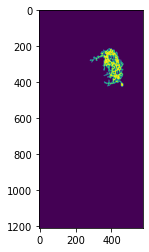

In [15]:
plt.imshow(np.max(transformed_em_neuron,axis = 2))